# 🔍 Lab8 Overview: Multimodal Contrastive Representation Learning

In this lab, you'll build and analyze a compact **multimodal contrastive representation learning** system that aligns images with text embeddings. The goal is to understand how contrastive objectives can produce a shared embedding space across modalities.

You will:

- **Prepare** a filtered CIFAR-100 dataset and use a frozen **MobileNetV3 encoder** with a small trainable projection head.  
- **Train** the model using a symmetric contrastive (InfoNCE) loss to associate each image with its corresponding class word.  
- **Evaluate** the learned space through per-class similarity statistics, retrieval performance, confusion matrices, and embedding visualizations.  
- **Test generalization** by applying the model to out-of-distribution (OOD) images.  
- **Interpret** the structure and behaviour of the multimodal embedding space.


In [ ]:
import os
import sys
import torch
import torch.nn.functional as F

# Ensure we import from the correct directory (Q6, not AI__Code)
Q6_PATH = '/Users/voodoo/Documents/Artificial Intelligence/Q6'
if Q6_PATH not in sys.path:
    sys.path.insert(0, Q6_PATH)

# Importing text processing, analysis, and data utilities from previous labs.
# (lab2: text_network, lab6: text prep/analysis, lab7: text/image prep/analysis)
from lab2 import process_text_network
from lab6 import prepare_visual_genome_text, filter_punctuation_from_network, analyze_embeddings, find_similar_words
from lab7 import create_mappings, compute_embedding_stats, get_cifar100_vocabulary, analyze_vocabulary_overlap, run_sanity_checks

# Importing all core components for the multimodal training pipeline and
# evaluation from the main script (lab8).
import importlib
import lab8
importlib.reload(lab8)  # Force reload to get the fixed version

from lab8 import (
    CIFAR100Filtered,
    ImageEncoder,
    filter_dataset_indices,
    create_data_splits,
    create_dataloaders,
    train_with_early_stopping,
    run_epoch,
    collect_embeddings,
    print_analysis_results,
    create_visualizations,
    print_example_retrievals,
    process_ood_images,
    compute_alignment_metrics,
    print_final_report
)

device = torch.device("mps")
print(f"Using device: {device} (Apple Silicon GPU)")

/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Using device: mps (Apple Silicon GPU)


In [ ]:
# =============================================================================
# 🚀 STAGE 1: Load Pre-trained Text Embeddings
# =============================================================================


MODEL_PATH = 'EMB32_NG10_CS2_BS64.pth'
checkpoint = torch.load(MODEL_PATH, map_location='cpu')

nodes = checkpoint['nodes']
vocab_size = checkpoint['vocab_size']
embedding_dim = checkpoint['embedding_dim']

# Get embeddings directly from state_dict
embeddings = checkpoint['model_state_dict']['center_embeddings.weight'].numpy()

# Create word-index mappings
word_to_idx, idx_to_word = create_mappings(nodes)

print(f"✓ Loaded {vocab_size} word embeddings (dim={embedding_dim})")
print(f"  Sample words: {nodes[:5]}")


[STAGE 1] Loading Pre-trained Text Embeddings
----------------------------------------------------------------------
✓ Loaded 523 word embeddings (dim=32)
  Sample words: ['a', 'the', 'on', 'of', 'is']


In [3]:

# This stage performs checks

# 2. 📝 Vocabulary Analysis & Target Selection
# The goal is to align images (CIFAR-100) with text embeddings (Visual Genome).
# We must ensure that the class names (e.g., 'cat', 'bicycle') exist in our text vocabulary.

print("\nVocabulary Analysis & Target Selection")
print("-" * 70)

cifar_vocab = get_cifar100_vocabulary()

missing_cifar_words = analyze_vocabulary_overlap(cifar_vocab, nodes)

# 3. 📊 Report Overlap Statistics
# The list of missing words shows the classes we must exclude from the training process.
# This filtered set of classes will be our final set of "seen" classes for alignment training.

n_train_classes = len(cifar_vocab) - len(missing_cifar_words)

print(f"\nSummary of Vocabulary Overlap:")
print(f"  Total CIFAR-100 Classes: {len(cifar_vocab)}")
print(f"  Classes available in VG vocabulary: {n_train_classes} (i.e., {n_train_classes/len(cifar_vocab)*100:.1f}% coverage)")
print(f"  Missing CIFAR-100 Classes: {len(missing_cifar_words)} (will be excluded from training)")


Vocabulary Analysis & Target Selection
----------------------------------------------------------------------

Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes

VOCABULARY OVERLAP ANALYSIS
CIFAR-100 vocabulary: 100 classes
Network vocabulary: 523 words
Overlapping words: 100 (100.0%)
Missing from network: 0

Found: apple, aquarium_fish, baby, bear, beaver, bed, bee, beetle, bicycle, bottle, bowl, boy, bridge, bus, butterfly, camel, can, castle, caterpillar, cattle, chair, chimpanzee, clock, cloud, cockroach, couch, crab, crocodile, cup, dinosaur, dolphin, elephant, flatfish, forest, fox, girl, hamster, house, kangaroo, keyboard, lamp, lawn_mower, leopard, lion, lizard, lobster, man, maple_tree, motorcycle, mountain, mouse, mushroom, oak_tree, orange, orchid, otter, palm_tree, pear, pickup_truck, pine_tree, plain, plate, poppy, porcupine, possum, rabbit, raccoon, ray, road, rocket, rose, sea, seal, shark, shrew, skunk, skyscraper, snail, snake, spider, squirre

In [4]:
# NOTE CHECKING THE WORDS IN THE MODEL 

# Print all 523 words
print(f"Total words in model: {len(nodes)}")
print(f"\nAll words:\n{nodes}")

# Check CIFAR-100 overlap
cifar_in_vocab = [w for w in cifar_vocab if w in nodes]
cifar_missing = [w for w in cifar_vocab if w not in nodes]

print(f"\n{'='*70}")
print(f"CIFAR-100 words IN vocabulary: {len(cifar_in_vocab)}")
print(cifar_in_vocab)

print(f"\nCIFAR-100 words MISSING: {len(cifar_missing)}")
print(cifar_missing)

Total words in model: 523

All words:
['a', 'the', 'on', 'of', 'is', 'in', 'white', 'black', 'and', 'man', 'with', 'blue', 'red', 'green', 'wearing', 'brown', 'building', 'are', 'person', 'woman', 'this', 'wall', 'sky', 'window', 'yellow', 'shirt', 'sign', 'water', 'table', 'to', 'has', 'tree', 'light', 'train', 'two', 'grass', 'an', 'side', 'large', 'small', 'street', 'front', 'ground', 'top', 'plate', 'car', 'part', 'orange', 'head', 'clouds', 'wooden', 'standing', 'bus', 'pole', 'sitting', 'metal', 'behind', 'holding', 'color', 'trees', 'silver', 'snow', 'gray', 'people', 'dog', 'hand', 'road', 'tennis', 'hair', 'grey', 'dark', 'glass', 'at', 'plane', 'back', 'floor', 'cat', 'background', 'fence', 'clock', 'door', 'giraffe', 'leaves', 'boy', 'left', 'field', 'right', 'next', 'long', 'by', 'bear', 'chair', 'elephant', 'tall', 'pink', "man's", 'girl', 'horse', 'pizza', 'for', 'baseball', 'zebra', 'pants', 'hat', 'boat', 'truck', 'walking', 'jacket', 'bench', 'sidewalk', 'it', 'hanging

# EXPERIMENTING WITH TRAINING CONFIGURATIONS

In [5]:
NEW_TRAIN_CONFIG = {
    'proj_dim': 32,
    'lr': 5e-4,              # ← Back to original (1e-3 might be too fast)
    'weight_decay': 1e-4,
    'temperature': 0.06,      
    'epochs': 100,
    'patience': 20,          # ← More patience
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v5.pth'
}

In [30]:
# NOTE ACRUAL TRAINING PROCEDURE: CLIP-Style Contrastive Learning Setup and Training

# This is the core stage where the visual encoder's projection head is trained
# to align image embeddings (CIFAR-100) with their corresponding text embeddings

print("\n[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary")
print("-" * 70)

# 2. 📝 Define Target Vocabulary and Embeddings

# Get the subset of CIFAR-100 class words that exist in the pre-trained VG vocabulary.
class_words = [w for w in cifar_vocab if w in word_to_idx]
print(f"\nOverlapping classes for training: {len(class_words)} / {len(cifar_vocab)}")
print(f"Training classes (first 5): {', '.join(class_words[:5])}...")

# Create label mapping for CIFAR-100 indices to their word and embedding index.
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Extract ALL text embeddings (Full Vocabulary)
# This full set of embeddings will be used later for **zero-shot prediction** on
# the test set, allowing the model to classify images against the entire VG vocabulary.
all_vocab_words = list(word_to_idx.keys())
all_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in all_vocab_words],
    dtype=torch.float32
).to(device)
all_text_emb = F.normalize(all_text_emb, p=2, dim=1) # Normalize embeddings for cosine similarity

# Extract ONLY the Training Class Embeddings (Subset)
# This subset is used *within the batch* for computing the **symmetric InfoNCE loss**
# ($\mathcal{L}_{I \to T} + \mathcal{L}_{T \to I}$).
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

print(f"\nText embedding configuration:")
print(f"  ├─ Full vocabulary embeddings (All VG words): {all_text_emb.shape[0]} words (for OOD analysis)")
print(f"  └─ Training class embeddings: {training_text_emb.shape[0]} classes (for contrastive learning)")

# 3. 💾 Data Preparation: Create Splits and DataLoaders
print("\n[Data Split] Creating Train/Val/Test splits...")

# Load the full CIFAR-100 datasets
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")

# Filter indices to include only samples belonging to the overlapping classes
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)

# Split the training data into training and validation sets
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)

print(f"Train samples: {len(train_idx):,} (for training the projection head)")
print(f"Val samples: {len(val_idx):,} (for early stopping)")
print(f"Test samples: {len(test_idx):,} (for final evaluation)")

# Create PyTorch DataLoaders for efficient batch processing
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, NEW_TRAIN_CONFIG['batch_sizes'])

# 4. 🧠 Initialize and Train Model
# The ImageEncoder uses a frozen MobileNetV3 backbone and a trainable projection head.
vision_model = ImageEncoder(proj_dim=NEW_TRAIN_CONFIG['proj_dim'], device=device)

# Start training with early stopping based on validation similarity
history, best_epoch, best_val_sim, best_val_loss = train_with_early_stopping(
    vision_model, dataloaders, training_text_emb, class_words,
    label_to_word, NEW_TRAIN_CONFIG, device
)

# 5. 🎉 Final Training Summary
print("\n" + "="*70)
print("✓ Training Complete!")
print(f"Best model from epoch {best_epoch}")
print(f"Best validation similarity: {best_val_sim:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")
print("="*70)


[STAGE 4] CLIP-Style Contrastive Learning with Full Vocabulary
----------------------------------------------------------------------

Overlapping classes for training: 100 / 100
Training classes (first 5): apple, aquarium_fish, baby, bear, beaver...

Text embedding configuration:
  ├─ Full vocabulary embeddings (All VG words): 523 words (for OOD analysis)
  └─ Training class embeddings: 100 classes (for contrastive learning)

[Data Split] Creating Train/Val/Test splits...
Train samples: 40,000 (for training the projection head)
Val samples: 10,000 (for early stopping)
Test samples: 10,000 (for final evaluation)


KeyboardInterrupt: 

In [7]:
# Load best model for evaluation
print("\n[Loading Best Model for Final Evaluation]")
vision_model = ImageEncoder(proj_dim=NEW_TRAIN_CONFIG['proj_dim'], device=device)

if not os.path.exists(NEW_TRAIN_CONFIG['save_path']):
    raise FileNotFoundError(f"Model checkpoint not found at {NEW_TRAIN_CONFIG['save_path']}. "
                           "Training must complete at least one epoch successfully.")

# Load the saved parameters and move the model to evaluation mode
checkpoint = torch.load(NEW_TRAIN_CONFIG['save_path'])
vision_model.load_state_dict(checkpoint['model_state_dict'])
vision_model.eval()

# Extract training metadata from checkpoint for reporting
best_epoch = checkpoint['epoch']
best_val_sim = checkpoint['val_similarity']
best_val_loss = checkpoint['val_loss']
history = checkpoint.get('history', None)

print(f"✓ Loaded best model from epoch {best_epoch}")
print(f"  Val Similarity: {best_val_sim:.4f}")


[Loading Best Model for Final Evaluation]
✓ Loaded best model from epoch 38
  Val Similarity: 0.4199


In [8]:
# =============================================================================
# FINAL TEST EVALUATION (using training classes)
# =============================================================================

dataloaders = create_dataloaders(train_idx, val_idx, test_idx, NEW_TRAIN_CONFIG['batch_sizes'])


print("\n" + "="*70)
print("FINAL TEST SET EVALUATION")
print("="*70)

# Run an evaluation epoch on the test dataloader. Note: 'training_text_emb'
# contains the embeddings for only the 80 overlapping classes.
test_loss, test_sim = run_epoch(
    vision_model, dataloaders['test'], training_text_emb, class_words,
    label_to_word, None, NEW_TRAIN_CONFIG['temperature'], device, 'eval'
)

print(f"\n📊 Test Results:")
print(f"  ├─ Test Loss: {test_loss:.4f} (InfoNCE)")
print(f"  └─ Test Similarity: {test_sim:.4f} (Average Cosine Similarity)")


FINAL TEST SET EVALUATION


  0%|          | 0/40 [00:00<?, ?it/s]/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
100%|██████████| 40/40 [00:21<00:00,  1.89it/s]


📊 Test Results:
  ├─ Test Loss: 1.7222 (InfoNCE)
  └─ Test Similarity: 0.4216 (Average Cosine Similarity)


In [15]:
# =============================================================================
# QUANTITATIVE ANALYSIS (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUANTITATIVE ANALYSIS")
print("="*70)

# 1. Collect all visual embeddings from the test set
visual_emb, all_labels = collect_embeddings(vision_model, dataloaders['test'], device)

# 2. Compute all alignment metrics in one pass
class_stats, i2t_recalls, t2i_recalls, sim_matrix = compute_alignment_metrics(
    visual_emb, all_labels, training_text_emb.cpu().numpy(), class_words, label_to_word
)

# 3. Print structured results for easy comparison
print_analysis_results(class_stats, i2t_recalls, t2i_recalls, len(all_labels), len(class_words))


QUANTITATIVE ANALYSIS


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. bicycle         | Mean: 0.6200 ± 0.1619
 2. bottle          | Mean: 0.6009 ± 0.2154
 3. motorcycle      | Mean: 0.5653 ± 0.1328
 4. keyboard        | Mean: 0.5429 ± 0.1448
 5. wardrobe        | Mean: 0.5198 ± 0.1104
 6. bus             | Mean: 0.5197 ± 0.2199
 7. orange          | Mean: 0.5193 ± 0.0954
 8. pear            | Mean: 0.4959 ± 0.1435
 9. streetcar       | Mean: 0.4873 ± 0.1715
10. chair           | Mean: 0.4838 ± 0.1482

Bottom 10 Worst Aligned Classes:
 1. man             | Mean: 0.3619 ± 0.1680
 2. seal            | Mean: 0.3514 ± 0.1288
 3. shrew           | Mean: 0.3447 ± 0.1228
 4. flatfish        | Mean: 0.3404 ± 0.1835
 5. girl            | Mean: 0.3389 ± 0.1368
 6. baby            | Mean: 0.3302 ± 0.1908
 7. lamp            | Mean: 0.3200 ± 0.2001
 8. woman           | Mean: 0.3117 ± 0.1853
 9. ray             | Mean: 0.2865 ± 0.


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b



GENERATING VISUALIZATIONS

📊 Creating confusion matrix...


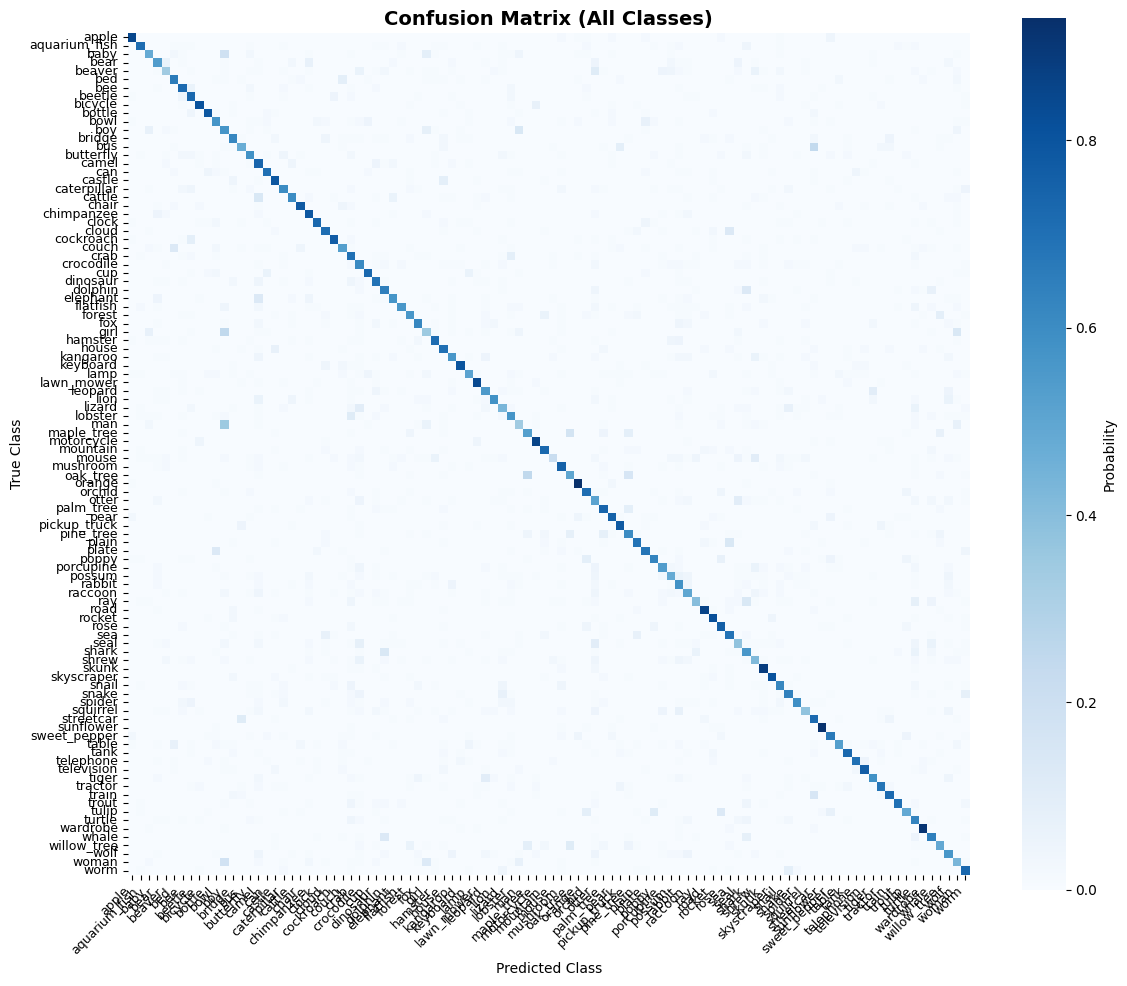


📸 Creating retrieval examples...


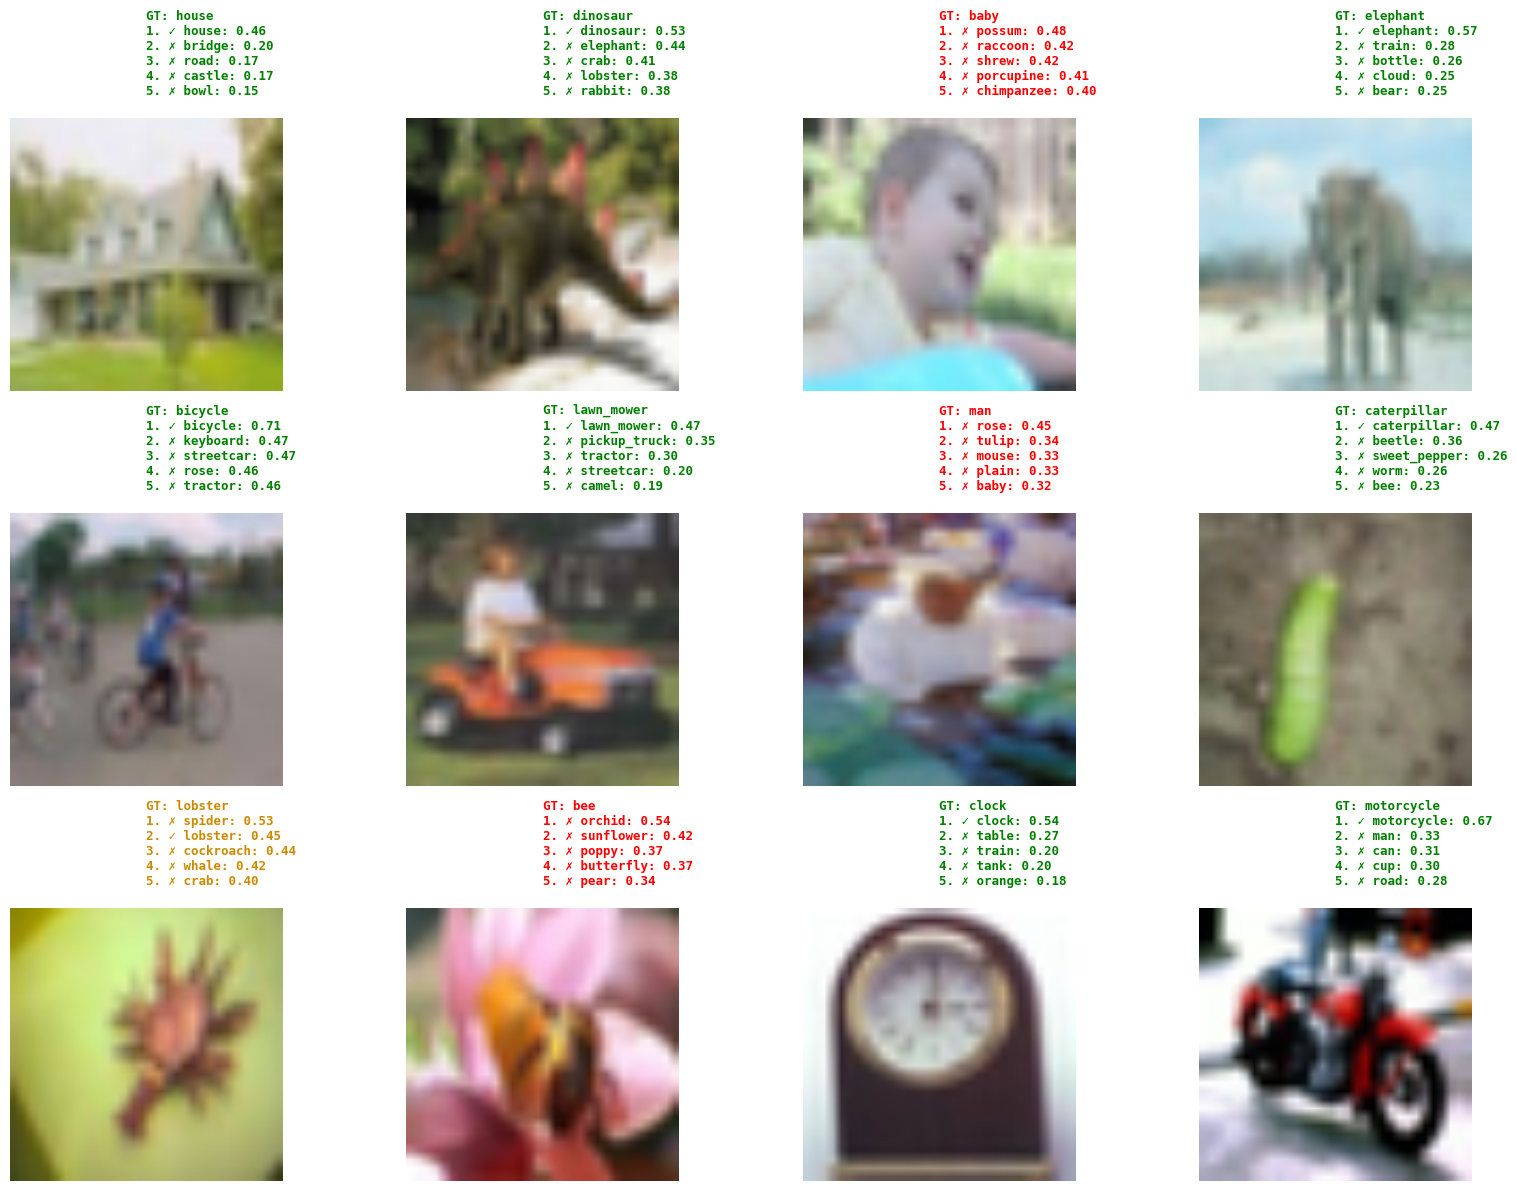


QUALITATIVE EVALUATION

📸 Example Image-to-Text Retrievals:
----------------------------------------------------------------------

Test Image #6463:
  True class: 'bee' (similarity: 0.4751, rank: 1)
  Top 5 predictions:
    1. ✓ bee             (similarity: 0.4751)
    2.   beetle          (similarity: 0.3270)
    3.   orchid          (similarity: 0.2853)
    4.   rabbit          (similarity: 0.2704)
    5.   caterpillar     (similarity: 0.2574)

Test Image #7427:
  True class: 'leopard' (similarity: 0.3263, rank: 8)
  Top 5 predictions:
    1.   snake           (similarity: 0.4670)
    2.   lizard          (similarity: 0.4658)
    3.   shark           (similarity: 0.4239)
    4.   whale           (similarity: 0.3746)
    5.   crocodile       (similarity: 0.3587)

Test Image #7849:
  True class: 'crab' (similarity: 0.4313, rank: 1)
  Top 5 predictions:
    1. ✓ crab            (similarity: 0.4313)
    2.   lobster         (similarity: 0.2629)
    3.   snail           (similarity: 0.2

In [10]:
# =============================================================================
# VISUALIZATIONS (using training classes)
# =============================================================================
print("\n" + "="*70)
print("GENERATING VISUALIZATIONS")
print("="*70)

# Creates and saves confusion matrix and retrieval examples (plots are shown interactively)
create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx)

# =============================================================================
# QUALITATIVE EVALUATION (using training classes)
# =============================================================================
print("\n" + "="*70)
print("QUALITATIVE EVALUATION")
print("="*70)

# Prints text-based examples of image-to-text retrieval for a random sample of test images
print_example_retrievals(sim_matrix, all_labels, class_words, label_to_word)


OUT-OF-DISTRIBUTION IMAGE ANALYSIS

🔬 Using FULL vocabulary (523 words) for OOD predictions
   (Training only learned to separate 100 classes)

  ✓ Downloaded: jellyfish
  ✓ Downloaded: goldfish
  ✓ Downloaded: flamingo
  ✓ Downloaded: pizza
  ✓ Downloaded: strawberry
  ✓ Downloaded: hotdog
  ✓ Downloaded: banana
  ✓ Downloaded: parachute
  ✓ Downloaded: school_bus
  ✓ Downloaded: volcano
  ✓ Downloaded: submarine
  ✓ Downloaded: accordion
  ✓ Downloaded: hourglass
  ✓ Downloaded: revolver
  ✓ Downloaded: dome
  ✓ Downloaded: bobsled

🔬 Processing 16 OOD images...


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:2


📸 Creating OOD visualization for 16 images...


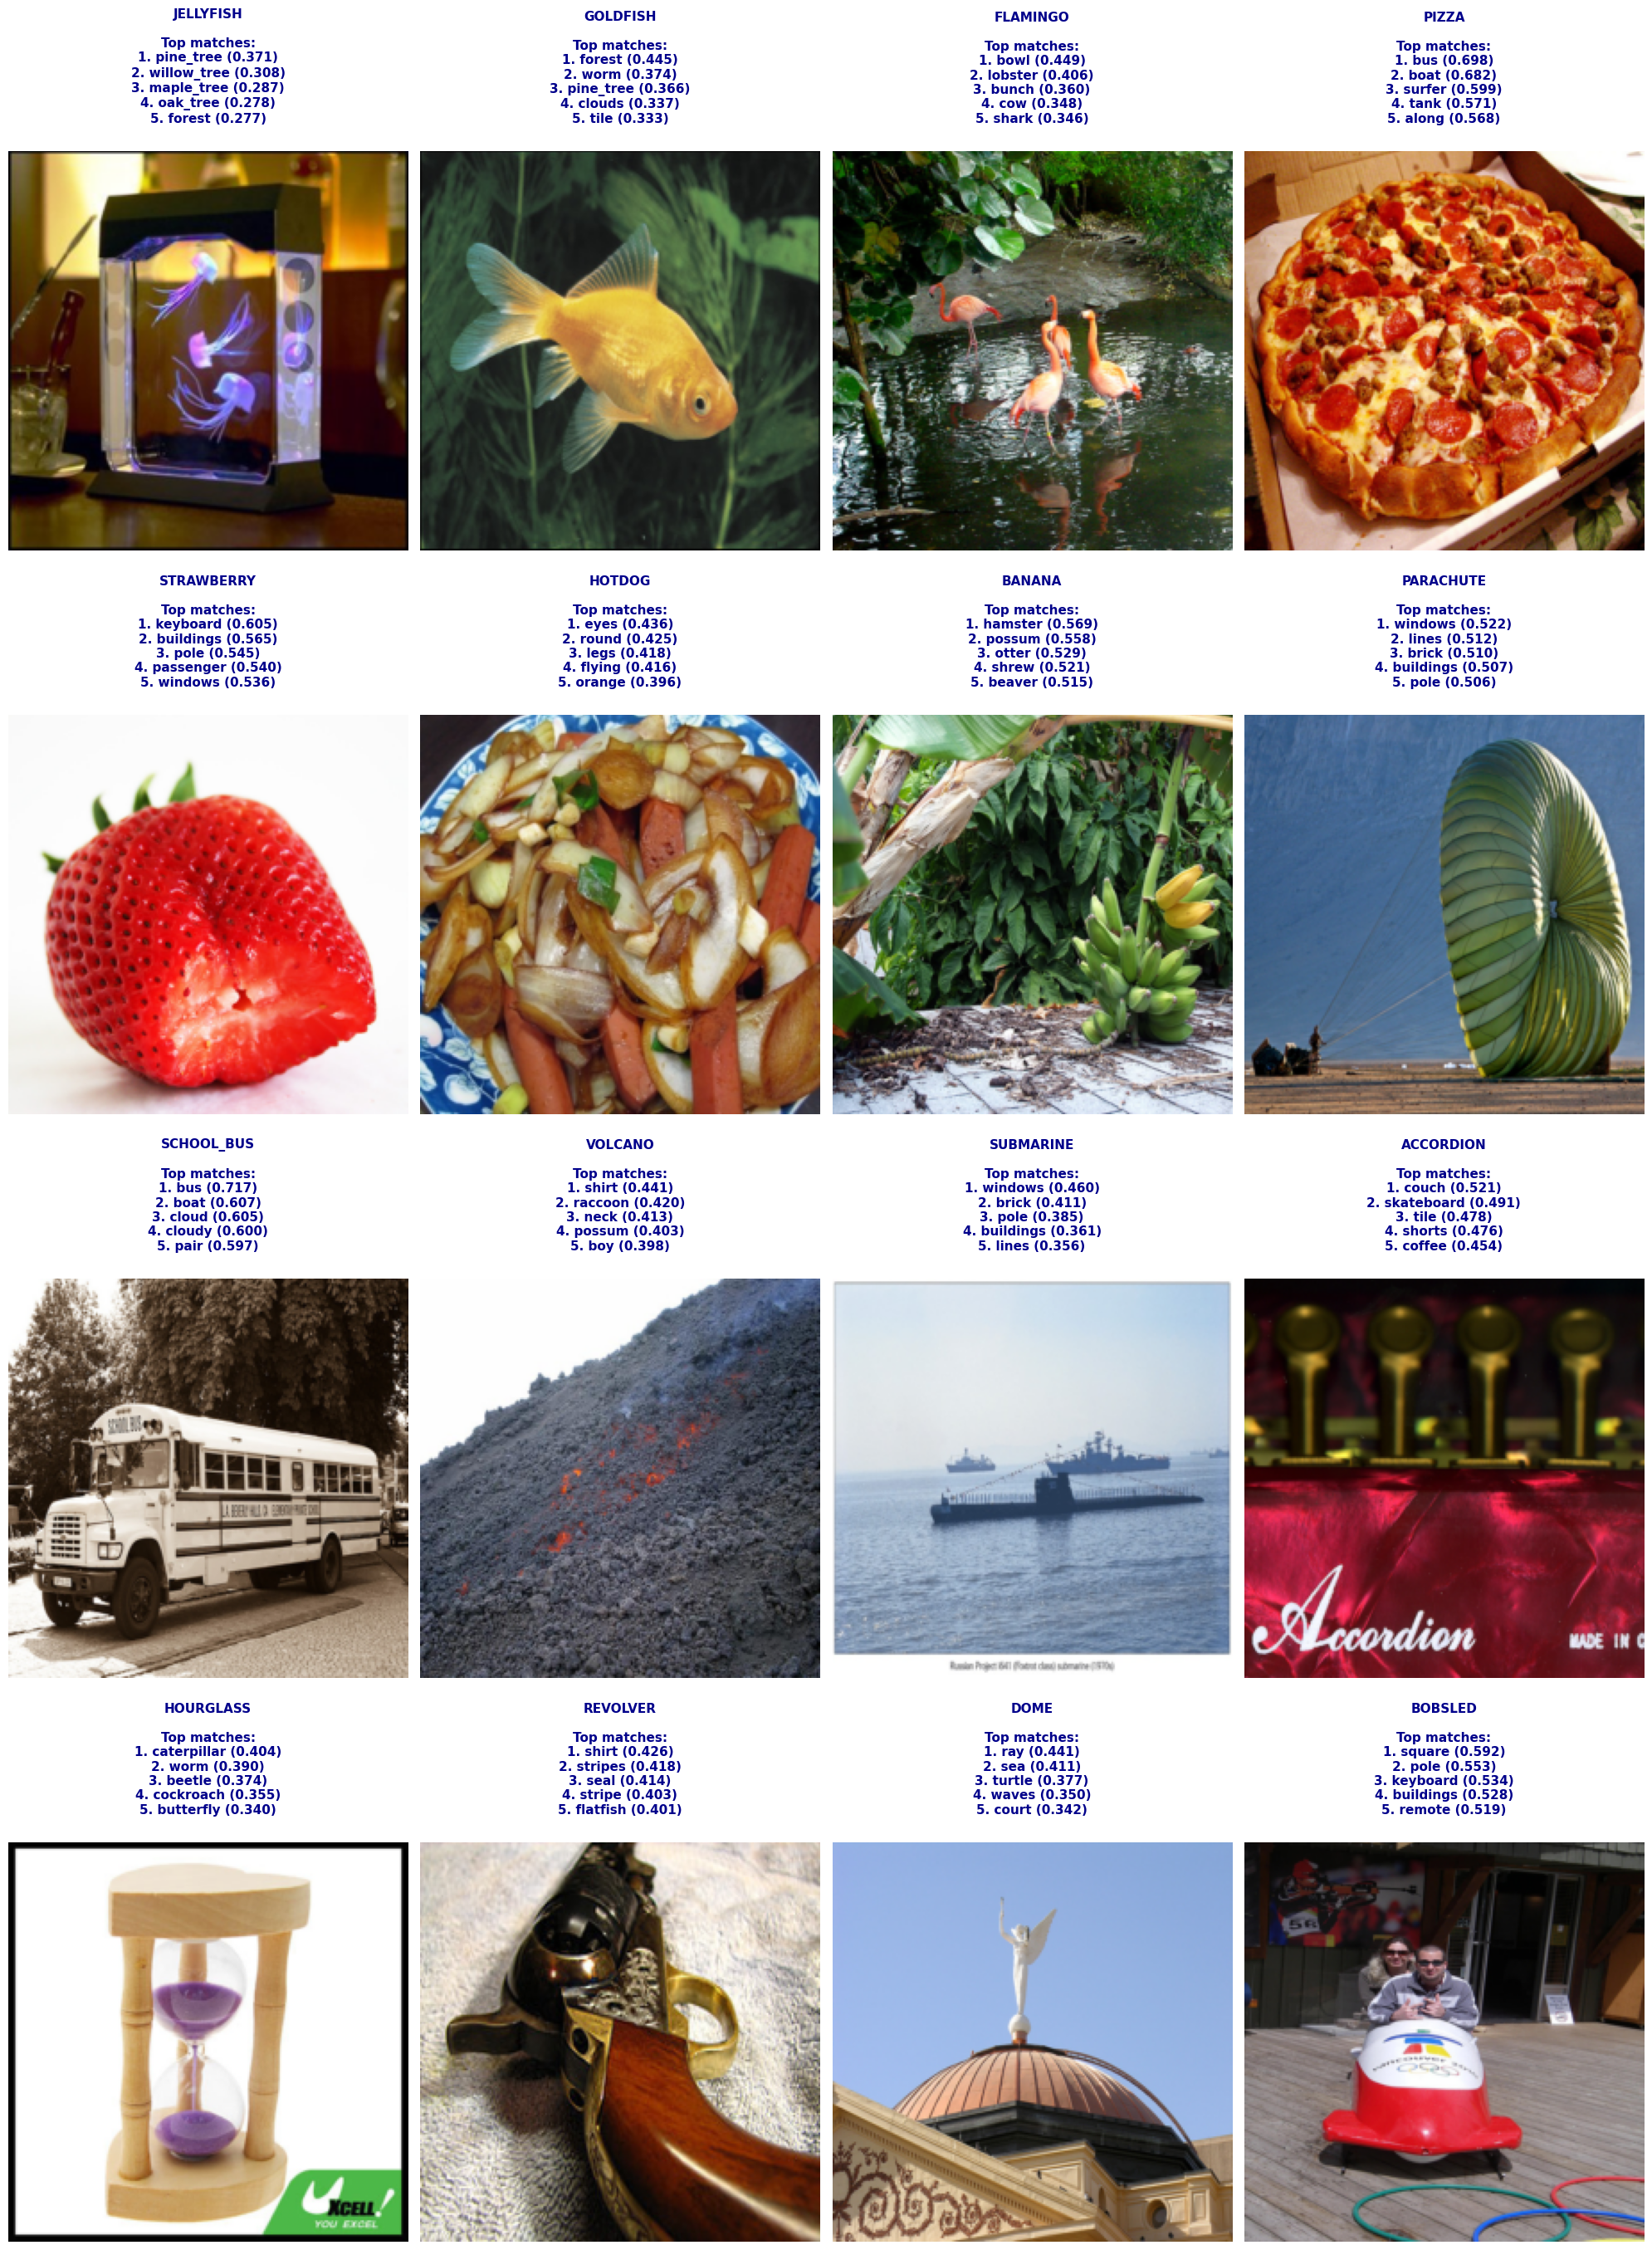

In [11]:
# OOD test images (samples outside of the CIFAR-100 domain)
OOD_URLS = {
    "jellyfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01910747_jellyfish.JPEG",
    "goldfish": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_goldfish.JPEG",
    "flamingo": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_flamingo.JPEG",
    "pizza": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07873807_pizza.JPEG",
    "strawberry": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07745940_strawberry.JPEG",
    "hotdog": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07697537_hotdog.JPEG",
    "banana": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07753592_banana.JPEG",
    "parachute": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03888257_parachute.JPEG",
    "school_bus": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04146614_school_bus.JPEG",
    "volcano": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n09472597_volcano.JPEG",
    "submarine": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04347754_submarine.JPEG",
    "accordion": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02672831_accordion.JPEG",
    "hourglass": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03544143_hourglass.JPEG",
    "revolver": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n04086273_revolver.JPEG",
    "dome": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03220513_dome.JPEG",
    "bobsled": "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02860847_bobsled.JPEG",
}

# =============================================================================
# OOD IMAGE ANALYSIS (using ALL vocabulary words)
# =============================================================================
print("\n" + "="*70)
print("OUT-OF-DISTRIBUTION IMAGE ANALYSIS")
print("="*70)

print(f"\n🔬 Using FULL vocabulary ({len(all_vocab_words):,} words) for OOD predictions")
print(f"   (Training only learned to separate {len(class_words)} classes)")

# This function processes the OOD images and calculates predictions against the full vocabulary.
# all_text_emb was prepared in STAGE 4 and contains embeddings for all {vocab_size} VG words.
ood_images, ood_names, ood_predictions = process_ood_images(
    vision_model, OOD_URLS, all_text_emb.cpu().numpy(), all_vocab_words, device
)

# If any images were successfully downloaded and processed, generate a visualization.
if len(ood_images) > 0:
    # The visualization function is reused, but now receives the OOD data
    # (images, names, predictions) to create a dedicated analysis plot.
    create_visualizations(sim_matrix, all_labels, class_words, label_to_word, test_idx,
                         ood_images, ood_names, ood_predictions)

In [24]:
# =============================================================================
# FINAL REPORT
# =============================================================================
# The final report function gathers all collected metrics and parameters
# (from TRAIN_CONFIG, test results, retrieval metrics, and OOD analysis)
# to print a comprehensive, structured summary.

print_final_report(
    NEW_TRAIN_CONFIG, test_loss, test_sim, i2t_recalls, t2i_recalls, class_stats,
    len(train_idx), len(val_idx), len(test_idx), len(class_words),
    NEW_TRAIN_CONFIG['batch_sizes']['train'], len(ood_images) > 0,
    history, best_epoch, best_val_sim, best_val_loss, len(all_vocab_words)
    )


📋 Training Configuration:
   ├─ Model: MobileNetV3-Small with projection head
   ├─ Embedding dimension: 32
   ├─ Training samples: 40,000, Validation samples: 10,000, Test samples: 10,000
   ├─ Number of training classes: 100
   ├─ Total vocabulary size: 523 words
   ├─ Total epochs trained: 38, Best epoch: 38
   └─ Early stopping patience: 20

🎯 Performance Metrics:
   ├─ Best Val Similarity: 0.4199
   ├─ Test Similarity: 0.4216, Test Loss: 1.7222
   ├─ Random baseline loss: ~6.93
   │
   ├─ Image→Text Recall@1: 63.94%
   ├─ Image→Text Recall@5: 81.24%
   ├─ Image→Text Recall@10: 86.33%
   │
   ├─ Text→Image Recall@1: 51.00%
   ├─ Text→Image Recall@5: 94.00%
   └─ Text→Image Recall@10: 98.00%

📊 Embedding Space Alignment:
   ├─ Mean per-class similarity: 0.4216 ± 0.0595
   ├─ Best aligned class: 'bicycle' (0.6200)
   └─ Worst aligned class: 'mouse' (0.1915)

💡 Key Insights:
   • The model attempts to learn visual-text alignment
   • Low overall alignment (similarity: 0.4216)
   • Lo

In [13]:
from lab8 import run_tests

run_tests()

ImportError: cannot import name 'run_tests' from 'lab8' (/Users/voodoo/Documents/Artificial Intelligence/Q6/lab8.py)

In [29]:
import torch

checkpoint = torch.load('best_clip_vision_model.pth', map_location='cpu')
print(checkpoint.keys())  # See what's saved

# If it has 'model_state_dict':
state_dict = checkpoint['model_state_dict']
for name, param in state_dict.items():
    print(f"{name}: {param.shape}")


FileNotFoundError: [Errno 2] No such file or directory: 'best_clip_vision_model.pth'

In [ ]:
import torch
checkpoint = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
print('Keys:', list(checkpoint.keys()))
for key in checkpoint.keys():
    val = checkpoint[key]
    if hasattr(val, 'shape'):
        print(f'{key}: shape = {val.shape}')
    elif isinstance(val, list):
        print(f'{key}: list of {len(val)} items, first 5: {val[:5]}')
    else:
        print(f'{key}: {type(val).__name__}')

Keys: ['model_state_dict', 'nodes', 'vocab_size', 'embedding_dim']
model_state_dict: OrderedDict
nodes: list of 523 items, first 5: ['a', 'the', 'on', 'of', 'is']
vocab_size: int
embedding_dim: int


----------------------------------
# **COMPARING ALL MODELS**

In [ ]:
V2_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.2,          # ← Higher than v3
    'epochs': 100,
    'patience': 15,              # ← Less patience than v3
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v2.pth',
    
    # Projection head architecture (same as v3)
    'projection_head': [
        ('Linear', 576, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}


checkpoint_v2 = torch.load('new_config_clip_vision_model_v2.pth', map_location='cpu')

print("Model v2 saved stats:")
print(f"  Best epoch: {checkpoint_v2['epoch']}")
print(f"  Val Similarity: {checkpoint_v2['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v2['val_loss']:.4f}")


Model v3 saved stats:
  Best epoch: 18
  Val Similarity: 0.4076
  Val Loss: 1.9270


In [ ]:

# Check saved model stats
import torch

V3_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.1,
    'epochs': 100,
    'patience': 20,
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v3.pth',
    
    # Projection head architecture
    'projection_head': [
        ('Linear', 576, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}

checkpoint_v3 = torch.load('new_config_clip_vision_model_v3.pth', map_location='cpu')

print("Model v3 saved stats:")
print(f"  Best epoch: {checkpoint_v3['epoch']}")
print(f"  Val Similarity: {checkpoint_v3['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v3['val_loss']:.4f}")

Model v3 saved stats:
  Best epoch: 23
  Val Similarity: 0.4446
  Val Loss: 2.9898


In [ ]:
v4_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.07,         # ← CLIP's temperature
    'epochs': 100,
    'patience': 20,
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v4.pth',
    
    # Projection head architecture
    'projection_head': [
        ('Linear', 576, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}

checkpoint_v4 = torch.load('new_config_clip_vision_model_v3.pth', map_location='cpu')

print("Model v4 saved stats:")
print(f"  Best epoch: {checkpoint_v4['epoch']}")
print(f"  Val Similarity: {checkpoint_v4['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v4['val_loss']:.4f}")

Model v4 saved stats:
  Best epoch: 18
  Val Similarity: 0.4076
  Val Loss: 1.9270


In [ ]:
# NOTE REASSESS v2

# === Setup (if running standalone) ===
# Load text embeddings
checkpoint_text = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
nodes = checkpoint_text['nodes']
embeddings = checkpoint_text['model_state_dict']['center_embeddings.weight'].numpy()
word_to_idx, idx_to_word = create_mappings(nodes)

# Get CIFAR vocab and create mappings
cifar_vocab = get_cifar100_vocabulary()
class_words = [w for w in cifar_vocab if w in word_to_idx]
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Create text embeddings tensor
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

# Create dataloaders
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, {'train': 1024, 'eval': 256})

# === Now load and evaluate v2 ===
checkpoint_v2 = torch.load('new_config_clip_vision_model_v2.pth', map_location=device)

print("=== REASSESSING v2 ===")
print(f"Loaded from epoch: {checkpoint_v2['epoch']}")
print(f"Val Similarity: {checkpoint_v2['val_similarity']:.4f}")

vision_model_v2 = ImageEncoder(proj_dim=32, device=device)
vision_model_v2.load_state_dict(checkpoint_v2['model_state_dict'])
vision_model_v2.eval()

visual_emb_v2, all_labels_v2 = collect_embeddings(vision_model_v2, dataloaders['test'], device)

class_stats_v2, i2t_recalls_v2, t2i_recalls_v2, sim_matrix_v2 = compute_alignment_metrics(
    visual_emb_v2, all_labels_v2, training_text_emb.cpu().numpy(), class_words, label_to_word
)

print_analysis_results(class_stats_v2, i2t_recalls_v2, t2i_recalls_v2, len(all_labels_v2), len(class_words))


Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes


/var/folders/9m/37dg7j617sq6gzsrv3mv9hc40000gn/T/ipykernel_20348/795656295.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  training_text_emb = torch.tensor(


=== REASSESSING v2 ===
Loaded from epoch: 23
Val Similarity: 0.4446


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. motorcycle      | Mean: 0.5626 ± 0.0992
 2. oak_tree        | Mean: 0.5549 ± 0.0691
 3. bicycle         | Mean: 0.5354 ± 0.1724
 4. keyboard        | Mean: 0.5339 ± 0.1584
 5. sunflower       | Mean: 0.5249 ± 0.0955
 6. wardrobe        | Mean: 0.5214 ± 0.1474
 7. chair           | Mean: 0.5195 ± 0.1670
 8. poppy           | Mean: 0.5180 ± 0.1525
 9. sweet_pepper    | Mean: 0.5133 ± 0.1407
10. cup             | Mean: 0.5098 ± 0.1429

Bottom 10 Worst Aligned Classes:
 1. flatfish        | Mean: 0.3819 ± 0.1679
 2. forest          | Mean: 0.3782 ± 0.1692
 3. castle          | Mean: 0.3770 ± 0.2278
 4. bus             | Mean: 0.3761 ± 0.1777
 5. seal            | Mean: 0.3695 ± 0.1471
 6. couch           | Mean: 0.3525 ± 0.2250
 7. bowl            | Mean: 0.3344 ± 0.1918
 8. ray             | Mean: 0.3184 ± 0.1920
 9. woman           | Mean: 0.2929 ± 0.


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# NOTE REASSESS v3

# === Setup (if running standalone) ===
# Load text embeddings
checkpoint_text = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
nodes = checkpoint_text['nodes']
embeddings = checkpoint_text['model_state_dict']['center_embeddings.weight'].numpy()
word_to_idx, idx_to_word = create_mappings(nodes)

# Get CIFAR vocab and create mappings
cifar_vocab = get_cifar100_vocabulary()
class_words = [w for w in cifar_vocab if w in word_to_idx]
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Create text embeddings tensor
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

# Create dataloaders
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, {'train': 1024, 'eval': 256})

# === Now load and evaluate v3 ===
checkpoint_v3 = torch.load('new_config_clip_vision_model_v3.pth', map_location=device)

print("=== REASSESSING v3 ===")
print(f"Loaded from epoch: {checkpoint_v3['epoch']}")
print(f"Val Similarity: {checkpoint_v3['val_similarity']:.4f}")

vision_model_v3 = ImageEncoder(proj_dim=32, device=device)
vision_model_v3.load_state_dict(checkpoint_v3['model_state_dict'])
vision_model_v3.eval()

visual_emb_v3, all_labels_v3 = collect_embeddings(vision_model_v3, dataloaders['test'], device)

class_stats_v3, i2t_recalls_v3, t2i_recalls_v3, sim_matrix_v3 = compute_alignment_metrics(
    visual_emb_v3, all_labels_v3, training_text_emb.cpu().numpy(), class_words, label_to_word
)

print_analysis_results(class_stats_v3, i2t_recalls_v3, t2i_recalls_v3, len(all_labels_v3), len(class_words))


Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes
=== REASSESSING v3 ===
Loaded from epoch: 18
Val Similarity: 0.4076


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. bicycle         | Mean: 0.6020 ± 0.1431
 2. bottle          | Mean: 0.5886 ± 0.1901
 3. motorcycle      | Mean: 0.5637 ± 0.1295
 4. pickup_truck    | Mean: 0.5615 ± 0.1530
 5. wardrobe        | Mean: 0.5278 ± 0.0997
 6. streetcar       | Mean: 0.5177 ± 0.1567
 7. pear            | Mean: 0.5065 ± 0.1252
 8. keyboard        | Mean: 0.5059 ± 0.1307
 9. sunflower       | Mean: 0.4976 ± 0.0814
10. bus             | Mean: 0.4965 ± 0.1727

Bottom 10 Worst Aligned Classes:
 1. ray             | Mean: 0.3284 ± 0.1413
 2. otter           | Mean: 0.3261 ± 0.1276
 3. girl            | Mean: 0.3220 ± 0.1403
 4. baby            | Mean: 0.3218 ± 0.1688
 5. lizard          | Mean: 0.3216 ± 0.1481
 6. bridge          | Mean: 0.3185 ± 0.1505
 7. lamp            | Mean: 0.3166 ± 0.1909
 8. woman           | Mean: 0.3012 ± 0.1476
 9. shrew           | Mean: 0.2912 ± 0.


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [ ]:
# NOTE REASESS v4

# === Setup (if running standalone) ===
# Load text embeddings
checkpoint_text = torch.load('EMB32_NG10_CS2_BS64.pth', map_location='cpu')
nodes = checkpoint_text['nodes']
embeddings = checkpoint_text['model_state_dict']['center_embeddings.weight'].numpy()
word_to_idx, idx_to_word = create_mappings(nodes)

# Get CIFAR vocab and create mappings
cifar_vocab = get_cifar100_vocabulary()
class_words = [w for w in cifar_vocab if w in word_to_idx]
label_to_word = {i: word for i, word in enumerate(cifar_vocab)}
label_to_emb_idx = {i: word_to_idx[word] for i, word in enumerate(cifar_vocab) if word in word_to_idx}

# Create text embeddings tensor
training_text_emb = torch.tensor(
    [embeddings[word_to_idx[word]] for word in class_words],
    dtype=torch.float32
).to(device)
training_text_emb = F.normalize(training_text_emb, p=2, dim=1)

# Create dataloaders
train_full = CIFAR100Filtered(root="./data", split="train")
test_full = CIFAR100Filtered(root="./data", split="val")
all_train_idx = filter_dataset_indices(train_full, label_to_emb_idx)
test_idx = filter_dataset_indices(test_full, label_to_emb_idx)
train_idx, val_idx = create_data_splits(all_train_idx, val_ratio=0.2, seed=42)
dataloaders = create_dataloaders(train_idx, val_idx, test_idx, {'train': 1024, 'eval': 256})

# === Now load and evaluate v4 ===
checkpoint_v4 = torch.load('new_config_clip_vision_model_v4.pth', map_location=device)

print("=== REASSESSING v4 ===")
print(f"Loaded from epoch: {checkpoint_v4['epoch']}")
print(f"Val Similarity: {checkpoint_v4['val_similarity']:.4f}")

vision_model_v4 = ImageEncoder(proj_dim=32, device=device)
vision_model_v4.load_state_dict(checkpoint_v4['model_state_dict'])
vision_model_v4.eval()

visual_emb_v4, all_labels_v4 = collect_embeddings(vision_model_v4, dataloaders['test'], device)

class_stats_v4, i2t_recalls_v4, t2i_recalls_v4, sim_matrix_v4 = compute_alignment_metrics(
    visual_emb_v4, all_labels_v4, training_text_emb.cpu().numpy(), class_words, label_to_word
)

print_analysis_results(class_stats_v4, i2t_recalls_v4, t2i_recalls_v4, len(all_labels_v4), len(class_words))


Loading CIFAR-100 vocabulary...
✓ CIFAR-100 vocabulary loaded: 100 classes
=== REASSESSING v4 ===
Loaded from epoch: 18
Val Similarity: 0.4126


  warnings.warn(
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


📊 Per-Class Similarity Analysis:
----------------------------------------------------------------------

Top 10 Best Aligned Classes:
 1. bicycle         | Mean: 0.5937 ± 0.1617
 2. bottle          | Mean: 0.5824 ± 0.1860
 3. motorcycle      | Mean: 0.5611 ± 0.1243
 4. keyboard        | Mean: 0.5507 ± 0.1409
 5. orange          | Mean: 0.5409 ± 0.1022
 6. bus             | Mean: 0.5253 ± 0.1432
 7. pickup_truck    | Mean: 0.5192 ± 0.1629
 8. oak_tree        | Mean: 0.5110 ± 0.0863
 9. wardrobe        | Mean: 0.5051 ± 0.1204
10. train           | Mean: 0.4954 ± 0.1437

Bottom 10 Worst Aligned Classes:
 1. flatfish        | Mean: 0.3415 ± 0.1816
 2. possum          | Mean: 0.3379 ± 0.1567
 3. shrew           | Mean: 0.3353 ± 0.1347
 4. shark           | Mean: 0.3310 ± 0.1321
 5. baby            | Mean: 0.3291 ± 0.1740
 6. seal            | Mean: 0.3140 ± 0.1503
 7. rabbit          | Mean: 0.3106 ± 0.1410
 8. ray             | Mean: 0.3090 ± 0.1378
 9. mouse           | Mean: 0.2983 ± 0.


/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/voodoo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [18]:
# =============================================================================
# v5 CONFIGURATION (BEST MODEL)
# =============================================================================

v5_config = {
    # Training hyperparameters
    'proj_dim': 32,
    'lr': 5e-4,
    'weight_decay': 1e-4,
    'temperature': 0.07,
    'epochs': 100,
    'patience': 20,
    'batch_sizes': {'train': 1024, 'eval': 256},
    'save_path': 'new_config_clip_vision_model_v5.pth',
    
    # Projection head architecture (LARGE)
    # 576 → 2048 → BN → ReLU → Dropout(0.3)
    #     → 1024 → BN → ReLU → Dropout(0.2)
    #     → 512  → BN → ReLU
    #     → 32
    'projection_head': [
        ('Linear', 576, 2048),
        ('BatchNorm1d', 2048),
        ('ReLU',),
        ('Dropout', 0.3),
        ('Linear', 2048, 1024),
        ('BatchNorm1d', 1024),
        ('ReLU',),
        ('Dropout', 0.2),
        ('Linear', 1024, 512),
        ('BatchNorm1d', 512),
        ('ReLU',),
        ('Linear', 512, 32),
    ],
    
    # Text embeddings
    'text_model': 'EMB32_NG10_CS2_BS64.pth',
    'embedding_dim': 32,
}

checkpoint_v5 = torch.load('new_config_clip_vision_model_v5.pth', map_location='cpu')

print("Model v5 saved stats:")
print(f"  Best epoch: {checkpoint_v5['epoch']}")
print(f"  Val Similarity: {checkpoint_v5['val_similarity']:.4f}")
print(f"  Val Loss: {checkpoint_v5['val_loss']:.4f}")

# v5 RESULTS:
# - Val Similarity: 0.4271
# - I→T Recall@1: 65.07%  ← BEST
# - I→T Recall@5: 82.12%
# - I→T Recall@10: 86.79%
# - T→I Recall@1: 49.00%
# - T→I Recall@5: 94.00%
# - T→I Recall@10: 99.00%

Model v5 saved stats:
  Best epoch: 38
  Val Similarity: 0.4199
  Val Loss: 1.7500
